In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng

In [2]:
# Specify m, n
m = 700 #100;400;700
n = 1000
# Specify the mean and variance of noise \delta, which follows normal distribution.
mu = 0
# This can be changed.
sigma = 0.8
np.random.seed(1234)

## Acceleration GD for LMS

In [3]:
def LMS_data_generator(m,n,mu, sigma):
    # A is a matrix with size R^{m*n}
    
    A = np.empty([m,n])
    # ground truth 
    z = 10*np.random.rand(n,1)
    # create noise vector with the length equals to m
    for i in range(m):
        for j in range(n):
            A[i,j] = np.random.normal(mu, 1)
        norm_A_i = np.linalg.norm(A[i,:],2)
        # scale each row of A such that the norm of each row is equal to 1.
        A[i,:] = A[i,:]/norm_A_i
    delta = np.random.normal(mu, sigma, size=(m,1))
    return A, z, delta

In [4]:
# define a function compute least square loss function value.
def least_square(A,x,b):
    residual = np.matmul(A,x)-b
    loss = 0.5*np.linalg.norm(residual,2)**2
    return loss

In [5]:
def least_square_grad(A,y,b):
    residual = np.matmul(A,y)-b
    # gradient is A^T(Ax-b)
    grad = np.matmul(np.transpose(A),residual)
    return grad

In [6]:
def least_square_acc_grad(A,y,b,eta,x0,choice,loop):
    # accelerated gd method
    # choice of theta
    if choice == 0:
        theta = loop/(loop+3)
    elif choice == 1:
        theta = 0.2
    elif choice == 2:
        theta = 0
    grad = least_square_grad(A,y,b)
    x = y - eta*grad
    # acceleration
    y = x + theta*(x-x0)
    return y,x

In [7]:
A, z, delta = LMS_data_generator(m,n,mu,sigma)
# generate observations
b = np.matmul(A,z)+delta
# check about A,z,b's shape
print(A.shape)
print(z.shape)
print(delta.shape)
print(b.shape)
print(np.linalg.norm(A[1,:],2))

(700, 1000)
(1000, 1)
(700, 1)
(700, 1)
1.0


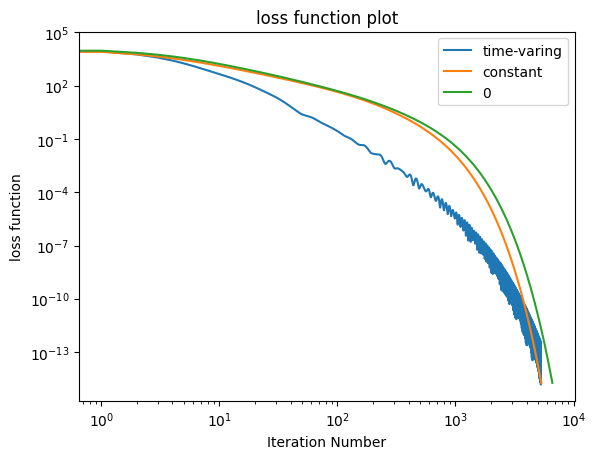

In [8]:
y0 = z+5*np.random.normal(1,1,size = (z.shape[0],z.shape[1]))
lr = 0.1
stop_criteria = 1e-8
norm_grad = np.linalg.norm(least_square_grad(A,y0,b),2)
err_ratio = np.linalg.norm(y0-z,2)/np.linalg.norm(z,2)
obj_val = np.empty(0)
estimation_err = np.empty(0)
#iter_vec = np.array([y0,y0])
loop = 0
x = y0
labels = ['time-varing', 'constant','0']
for choice in range(3):
    y0 = z+5*np.random.normal(1,1,size = (z.shape[0],z.shape[1]))
    lr = 0.1
    stop_criteria = 1e-8
    norm_grad = np.linalg.norm(least_square_grad(A,y0,b),2)
    err_ratio = np.linalg.norm(y0-z,2)/np.linalg.norm(z,2)
    obj_val = np.empty(0)
    estimation_err = np.empty(0)
    #iter_vec = np.array([y0,y0])
    loop = 0
    x = y0
    while norm_grad > stop_criteria:
    
        y0,x = least_square_acc_grad(A,y0,b,lr,x,choice, loop)
        grad = least_square_grad(A,y0,b)
        norm_grad = np.linalg.norm(grad,2)
        loss_val = least_square(A,y0,b)
        # record training loss and estimation error.
        #print(obj_val)
        obj_val = np.append(obj_val, loss_val)
    
        err_ratio = np.linalg.norm(y0-z,2)/np.linalg.norm(z,2)
        estimation_err = np.append(estimation_err, err_ratio)
        loop += 1
    # make a plot.
    plt.loglog(obj_val,label = labels[choice] )
    plt.xlabel('Iteration Number')
    plt.ylabel('loss function')
    plt.title('loss function plot')
    plt.legend()
    plt.savefig("Visualization of loss function", dpi = 150)


## Accelerate GD for Compressive Sensing

In [9]:
def sample_index(n,x):
    rng = default_rng()
    # sample 95% index to be 0.
    array_size = np.rint(n*0.95)
    index = rng.choice(n, size=array_size.astype(int), replace=False)
    index = np.sort(index)
    for i in index:
        x[i]=0
    return x

In [10]:
# define a function to generate experimental data.
# Input args: m,n are matrix shape; mu and sigma are for noise data.
def sparse_data_generator(m,n,mu, sigma):
    # A is a matrix with size R^{m*n}
    
    A = np.empty([m,n])
    # ground truth 
    original_z = 5*np.random.rand(n,1)
    # Sample sparse vector
    z = sample_index(n,original_z)
    # create noise vector with the length equals to m
    for i in range(m):
        for j in range(n):
            A[i,j] = np.random.normal(mu, 1)
        norm_A_i = np.linalg.norm(A[i,:],2)
        # scale each row of A such that the norm of each row is equal to 1.
        A[i,:] = A[i,:]/norm_A_i
    delta = np.random.normal(mu, sigma, size=(m,1))
    return A, z, delta

In [11]:
A, z, delta = sparse_data_generator(m,n,mu,sigma)
# generate observations
b = np.matmul(A,z)+delta
# check about A,z,b's shape
print(A.shape)
print(z.shape)
print(delta.shape)
print(b.shape)
print(np.linalg.norm(A[1,:],2))
print(A.shape[0])

(700, 1000)
(1000, 1)
(700, 1)
(700, 1)
1.0
700


In [12]:
# Check Sparsity of vector z.
print(z[1:20])

[[4.39420329]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [13]:
def L1_least_square(A,x,b,lambda0):
    residual = np.matmul(A,x)-b
    loss = 0.5*np.linalg.norm(residual,2)**2
    regularization = lambda0*np.linalg.norm(x,1)
    return loss+regularization

In [14]:
def least_square_grad(A,y,b):
    residual = np.matmul(A,y)-b
    # gradient is A^T(Ax-b)
    grad = np.matmul(np.transpose(A),residual)
    return grad

In [15]:
def proximal_operator_L1(x,lambda0):
    # proximal map.
    u = np.maximum(x-lambda0,0)
    return u*np.sign(u)

In [16]:
def CS_acc_grad(A,y,b,eta,x0,choice,loop):
    if choice == 0:
        theta = loop/(loop+3)
    elif choice == 1:
        theta = 0.2
    elif choice == 2:
        theta = 0
    grad = least_square_grad(A,y,b)
    x1_hat = y - eta*grad
    # proximal gd
    x =proximal_operator_L1(x1_hat,lambda0)
    # acceleration
    y = x + theta*(x-x0)
    return y,x

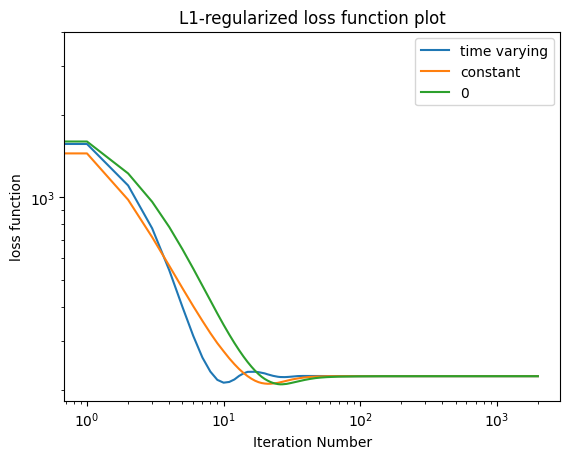

In [17]:
labels = ['time varying', 'constant', '0']
for choice in range(3):
    lr1 = 0.1
    y0 = z+3*np.random.normal(0,1,size = (z.shape[0],z.shape[1]))
    x = y0
    lambda0 = 0.1
    max_iter = 2000
    obj_val1 = np.empty(0)
    initial_val1 = least_square(A,y0,b)
    obj_val1 = np.append(obj_val1,initial_val1)
    estimation_vec1 = np.empty(0)
    #print(obj_val1)

    for j in range(max_iter):
        y0,x = CS_acc_grad(A,y0,b,lr1,x,choice,j)
        loss = L1_least_square(A,y0,b,lambda0)
        obj_val1 = np.append(obj_val1,loss)
        est_err1 = np.linalg.norm(y0-z,2)/np.linalg.norm(z,2)
        estimation_vec1 = np.append(estimation_vec1,est_err1)
    #print(est_err1)
    plt.loglog(obj_val1,label = labels[choice] )
    plt.xlabel('Iteration Number')
    plt.ylabel('loss function')
    plt.title('L1-regularized loss function plot')
    plt.legend()
    plt.savefig("Visualization of L1-regularized loss function", dpi = 150)

In [47]:
print(obj_val1)

[3609.34796357 1527.99603006 1157.06978466 ...  210.0658283   210.0658283
  210.0658283 ]
